Initial Imports

In [1]:
import pandas as pd 
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.backend import batch_normalization, dtype 

In [2]:
data = pd.read_csv("train_set.csv")
print(data.columns)

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding',
       'profile_id'],
      dtype='object')


In [3]:
print(data.head())

    ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182  1.029572   
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133  1.029509   
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431  1.029448   
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636  1.032845   
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701  1.031807   

        i_q        pm  stator_yoke  stator_tooth  stator_winding  profile_id  
0 -0.245860 -2.522071    -1.831422     -2.066143       -2.018033           4  
1 -0.245832 -2.522418    -1.830969     -2.064859       -2.017631           4  
2 -0.245818 -2.522673    -1.830400     -2.064073       -2.017343           4  
3 -0.246955 -2.521639    -1.830333     -2.063137       -2.017632           4  
4 -0.246610 -2.521900    -1.830498     -2.062795       -2.018145           4  


Check data for correctness by seeing if it contains data between 1 to 6 hours

checking if each profile contains data for 1 to 6 hours
session 4 lasted 4.64 hours
session 6 lasted 5.61 hours
session 10 lasted 2.12 hours
session 11 lasted 1.10 hours
potential anomaly in session 20 with 6.11 hours
session 20 lasted 6.11 hours
session 27 lasted 4.91 hours
session 29 lasted 2.97 hours
session 30 lasted 3.31 hours
session 36 lasted 3.14 hours
session 43 lasted 1.17 hours
session 44 lasted 3.66 hours
session 45 lasted 2.38 hours
potential anomaly in session 46 with 0.30 hours
session 46 lasted 0.30 hours
potential anomaly in session 47 with 0.30 hours
session 47 lasted 0.30 hours
session 48 lasted 3.05 hours
session 49 lasted 1.50 hours
session 50 lasted 1.50 hours
session 53 lasted 4.51 hours
session 54 lasted 1.50 hours
session 55 lasted 1.50 hours
session 56 lasted 4.60 hours
session 57 lasted 2.00 hours
session 58 lasted 4.64 hours
session 59 lasted 1.04 hours
session 60 lasted 2.02 hours
session 63 lasted 2.31 hours
potential anomaly in session 64 with 0.87 hours


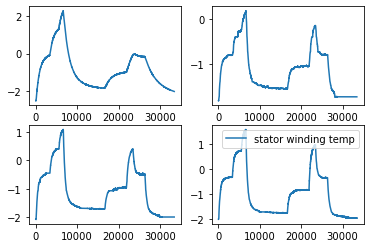

In [6]:
print("checking if each profile contains data for 1 to 6 hours")
for i in data['profile_id'].unique():
    len(data[data["profile_id"] == i])
    #each second, you get 2 values, for 1 hour, it should be count/(3600*2)
    hours = len(data[data["profile_id"] == i])/(3600*2)
    if(hours >= 6 or hours <= 1):
        print(f"potential anomaly in session {i} with {hours:.2f} hours")
    print(f'session {i} lasted {hours:.2f} hours')


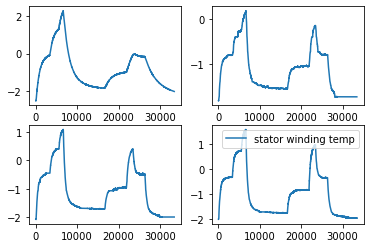

In [7]:
#for profile 4
data_p4 = data[data.profile_id == 4]
fig, ax = plt.subplots(2,2)
ax[0,0].plot(data_p4.pm, label="rotor temp")
ax[0,1].plot(data_p4.stator_yoke, label="stator yoke temp")
ax[1,0].plot(data_p4.stator_tooth, label="stator tooth temp")
ax[1,1].plot(data_p4.stator_winding, label="stator winding temp")

plt.legend()
plt.show()

note that all 4 seem to follow a similar pattern. Now lets plot it with respect to ambient temp 

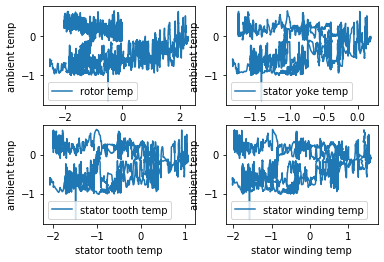

In [16]:
data_p4 = data[data.profile_id == 4]
fig, ax = plt.subplots(2,2)
ax[0,0].plot(data_p4.pm, data_p4.ambient, label="rotor temp")
ax[0,1].plot(data_p4.stator_yoke, data_p4.ambient, label="stator yoke temp")
ax[1,0].plot(data_p4.stator_tooth, data_p4.ambient, label="stator tooth temp")
ax[1,1].plot(data_p4.stator_winding, data_p4.ambient, label="stator winding temp")
ax[0,0].set_xlabel("rotor temp")
ax[0,1].set_xlabel("stator yoke temp")
ax[1,0].set_xlabel("stator tooth temp")
ax[1,1].set_xlabel("stator winding temp")
for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i,j].set_ylabel("ambient temp")
        ax[i,j].legend()


Now lets prepare the data for processing. For now, we only predict the rotor temperature

In [21]:
def get_data(data):
    data_X = data[['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
        'i_q', 'stator_yoke', 'stator_tooth', 'stator_winding','pm'
        ]]
    data_Y = data[['pm']]
    count = round(len(data)*0.7)
    X_train, Y_train,  = data_X.to_numpy()[:count,:], data_Y.to_numpy()[:count,:]
    X_valid, Y_valid,  = data_X.to_numpy()[count:,:], data_Y.to_numpy()[count:,:]
    print(f"X_train_shape initial = {X_train.shape} {X_valid.shape}")
    #TODO normalize data across row dimension
    def normalize_rows(x: np.ndarray):
        """
        function that normalizes each row of the matrix x to have unit length.

        Args:
        ``x``: A numpy matrix of shape (n, m)

        Returns:
        ``x``: The normalized (by row) numpy matrix.
        """
        return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)
    X_train = normalize_rows(X_train)
    X_valid = normalize_rows(X_valid)
    print(f"X_train_shape after normalize = {X_train.shape} {X_valid.shape}")
    X_train = X_train[:,:,np.newaxis]
    X_valid = X_valid[:,:,np.newaxis]

    return X_train, Y_train, X_valid, Y_valid
X_train, Y_train, X_valid, Y_valid = get_data(data_p4)
print(f"X_train_shape after adding axis = {X_train.shape} {X_valid.shape}")
print(f"Y_train_shape after adding axis = {Y_train.shape} {Y_valid.shape}")

X_train_shape initial = (23396, 12) (10027, 12)
X_train_shape after normalize = (23396, 12) (10027, 12)
X_train_shape after adding axis = (23396, 12, 1) (10027, 12, 1)
Y_train_shape after adding axis = (23396, 1) (10027, 1)


Basic recurrent sequence to vector model using Gated Recurrent Unit

In [22]:
tf.random.set_seed(42)
model = keras.models.Sequential(
    [keras.layers.GRU(10, return_sequences=True, input_shape=[None,1]),
    keras.layers.GRU(10, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation=None))
    ]
)
print(f"X_train_shape before processing = {X_train.shape}")
model.compile(loss="mse", optimizer="adam")
print(model.summary())
#model.predict(X_valid)


X_train_shape before processing = (23396, 12, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 10)          390       
_________________________________________________________________
gru_3 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
history = model.fit(X_train,Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
732/732 [==============================] - 6s 8ms/step - loss: 1.0144 - val_loss: 0.9333
Epoch 2/20
732/732 [==============================] - 5s 7ms/step - loss: 0.5217 - val_loss: 0.7511
Epoch 3/20
732/732 [==============================] - 5s 7ms/step - loss: 0.4181 - val_loss: 0.6097
Epoch 4/20
732/732 [==============================] - 5s 7ms/step - loss: 0.3726 - val_loss: 0.5771
Epoch 5/20
732/732 [==============================] - 5s 7ms/step - loss: 0.3510 - val_loss: 0.6529
Epoch 6/20
732/732 [==============================] - 5s 7ms/step - loss: 0.3328 - val_loss: 0.8496
Epoch 7/20
732/732 [==============================] - 5s 7ms/step - loss: 0.3177 - val_loss: 1.1220
Epoch 8/20
732/732 [==============================] - 5s 7ms/step - loss: 0.3037 - val_loss: 0.9238
Epoch 9/20
732/732 [==============================] - 5s 7ms/step - loss: 0.2924 - val_loss: 0.8891
Epoch 10/20
732/732 [==============================] - 5s 7ms/step - loss: 0.2812 - val_loss: 0.8260

Now we plot the results of the model training

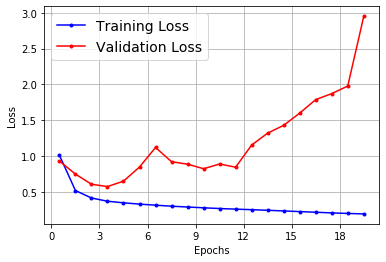

In [25]:
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss))+0.5,loss,"b.-",label="Training Loss")
    plt.plot(np.arange(len(val_loss))+0.5,val_loss,"r.-",label="Validation Loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history['loss'], history.history['val_loss'])

Based on above result, we see that the GRU model doesn't do well. Maybe it needs to learn for longer timesteps so we try LSTM 

In [39]:
tf.random.set_seed(42)
model = keras.models.Sequential(
    [keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20, return_sequences=True), 
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
    ]
)
print(f"X_train_shape before processing = {X_train.shape}")
model.compile(loss="mse", optimizer="adam")
print(model.summary())
history = model.fit(X_train,Y_train, epochs=20, validation_data=(X_valid, Y_valid))

X_train_shape before processing = (23396, 12, 1)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 20)          80        
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1)           21        
Total params: 5,141
Trainable params: 5,101
Non-trainable params: 40
_________________________________________________________________
None
Epoch 1/20
732/732 [==============================] - 7s 10ms/step - loss: 0.8417 - val_loss: 0.3790
Epoch 2/20
732/732 [==============================] - 6s 8ms/step - loss: 0.5932 - val_loss: 1

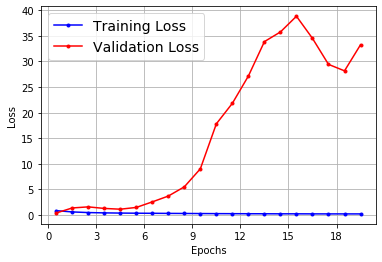

In [27]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

This seems to be better but still the loss increases a lot then reduces then increases again.
<br>
We now try a 1D convolution with selu activation and lecun_normal initialization.<br>
This type of model trains faster so we can train more epochs since it can be seen above that the LSTM model does start decreasing its loss after about 15 epochs.

In [47]:
model = keras.models.Sequential()
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule)
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate  in (1,2,4,8) *2:
    model.add(keras.layers.Conv1D(filters=40, kernel_size=2, padding="causal", 
                                  activation="selu", 
                                  kernel_initializer = "lecun_normal", 
                                  dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1,
                              activation="selu", 
                              kernel_initializer = "lecun_normal"))
model.compile(loss="mse", optimizer=optimizer,  metrics=[keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_valid, Y_valid))

Epoch 1/50
732/732 [==============================] - 5s 7ms/step - loss: 0.6834 - root_mean_squared_error: 0.8267 - val_loss: 0.5393 - val_root_mean_squared_error: 0.7343
Epoch 2/50
732/732 [==============================] - 5s 7ms/step - loss: 0.3671 - root_mean_squared_error: 0.6059 - val_loss: 0.5394 - val_root_mean_squared_error: 0.7345
Epoch 3/50
732/732 [==============================] - 5s 7ms/step - loss: 0.3146 - root_mean_squared_error: 0.5609 - val_loss: 0.7025 - val_root_mean_squared_error: 0.8381
Epoch 4/50
732/732 [==============================] - 5s 7ms/step - loss: 0.2959 - root_mean_squared_error: 0.5440 - val_loss: 0.6298 - val_root_mean_squared_error: 0.7936
Epoch 5/50
732/732 [==============================] - 5s 7ms/step - loss: 0.2844 - root_mean_squared_error: 0.5333 - val_loss: 0.7483 - val_root_mean_squared_error: 0.8651
Epoch 6/50
732/732 [==============================] - 5s 7ms/step - loss: 0.2743 - root_mean_squared_error: 0.5237 - val_loss: 1.1667 - val_

732/732 [==============================] - 5s 7ms/step - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 1.1221 - val_root_mean_squared_error: 1.0593
Epoch 49/50
732/732 [==============================] - 5s 7ms/step - loss: 0.1629 - root_mean_squared_error: 0.4036 - val_loss: 1.5848 - val_root_mean_squared_error: 1.2589
Epoch 50/50
732/732 [==============================] - 5s 7ms/step - loss: 0.1611 - root_mean_squared_error: 0.4014 - val_loss: 1.1274 - val_root_mean_squared_error: 1.0618


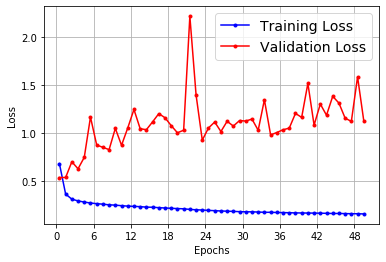

In [48]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

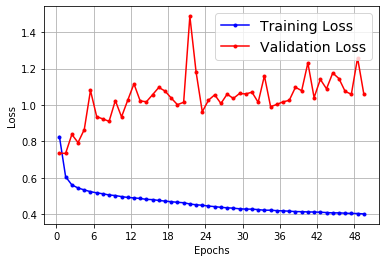

In [49]:
plot_learning_curves(history.history['root_mean_squared_error'], history.history['val_root_mean_squared_error'])

In [51]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None,1]),
    keras.layers.Dense(40,activation='selu', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(40, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)]
)


model.compile(loss=tf.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, None, 40)          80        
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40)          160       
_________________________________________________________________
dense_5 (Dense)              (None, None, 40)          1640      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 40)          160       
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           41        
Total params: 2,081
Trainable params: 1,921
Non-trainable params: 160
_________________________________________________________________
None


In [52]:
history = model.fit(X_train, Y_train, epochs=40, validation_data=(X_valid, Y_valid))

Epoch 1/40
732/732 [==============================] - 6s 8ms/step - loss: 1.2914 - root_mean_squared_error: 1.1364 - val_loss: 1.7241 - val_root_mean_squared_error: 1.3131
Epoch 2/40
732/732 [==============================] - 6s 8ms/step - loss: 1.0770 - root_mean_squared_error: 1.0378 - val_loss: 0.5928 - val_root_mean_squared_error: 0.7699
Epoch 3/40
732/732 [==============================] - 6s 8ms/step - loss: 1.0706 - root_mean_squared_error: 1.0347 - val_loss: 0.6660 - val_root_mean_squared_error: 0.8161
Epoch 4/40
732/732 [==============================] - 6s 8ms/step - loss: 1.0688 - root_mean_squared_error: 1.0338 - val_loss: 0.6727 - val_root_mean_squared_error: 0.8202
Epoch 5/40
732/732 [==============================] - 5s 7ms/step - loss: 1.0676 - root_mean_squared_error: 1.0333 - val_loss: 0.6734 - val_root_mean_squared_error: 0.8206
Epoch 6/40
732/732 [==============================] - 5s 7ms/step - loss: 1.0666 - root_mean_squared_error: 1.0328 - val_loss: 0.8283 - val_

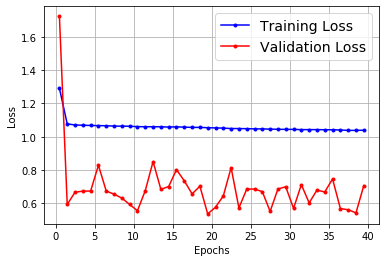

In [53]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

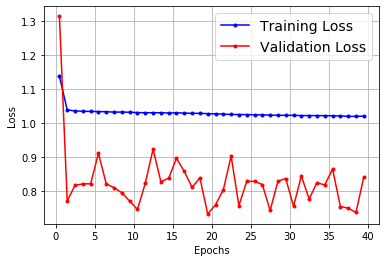

In [54]:
plot_learning_curves(history.history['root_mean_squared_error'], history.history['val_root_mean_squared_error'])

Now we try to predict all 4 values

In [55]:
'''predict multiple items ''' 
def get_data(data):
    data_X = data[['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
        'i_q',
        ]]
    data_Y = data[['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']]
    count = round(len(data)*0.7)
    X_train, Y_train,  = data_X.to_numpy()[:count,:], data_Y.to_numpy()[:count,:]
    X_valid, Y_valid,  = data_X.to_numpy()[count:,:], data_Y.to_numpy()[count:,:]
    print(f"X_train_shape initial = {X_train.shape} {X_valid.shape}")
    #TODO normalize data across row dimension
    def normalize_rows(x: np.ndarray):
        """
        function that normalizes each row of the matrix x to have unit length.

        Args:
        ``x``: A numpy matrix of shape (n, m)

        Returns:
        ``x``: The normalized (by row) numpy matrix.
        """
        return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)
    X_train = normalize_rows(X_train)
    X_valid = normalize_rows(X_valid)
    print(f"X_train_shape after normalize = {X_train.shape} {X_valid.shape}")
    X_train = X_train[:,:,np.newaxis]
    X_valid = X_valid[:,:,np.newaxis]
    Y_train = Y_train[:, np.newaxis,:]
    Y_valid = Y_valid[:, np.newaxis,:]
    return X_train, Y_train, X_valid, Y_valid
X_train, Y_train, X_valid, Y_valid = get_data(data_p4)

X_train_shape initial = (23396, 8) (10027, 8)
X_train_shape after normalize = (23396, 8) (10027, 8)


Since the sequential model worked best last time, we start with that

In [75]:
X_train, Y_train, X_valid, Y_valid = get_data(data_p4)
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None,1]),
    keras.layers.Dense(40,activation='selu', kernel_initializer="lecun_normal"),
    keras.layers.Dense(40, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(4)]
)

model.compile(loss=tf.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model.compile(loss=tf.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
print(model.summary())

X_train_shape initial = (23396, 8) (10027, 8)
X_train_shape after normalize = (23396, 8) (10027, 8)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, None, 40)          80        
_________________________________________________________________
dense_18 (Dense)             (None, None, 40)          1640      
_________________________________________________________________
dense_19 (Dense)             (None, None, 4)           164       
Total params: 1,884
Trainable params: 1,884
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
732/732 [==============================] - 5s 6ms/step - loss: 0.8352 - root_mean_squared_error: 0.9139 - val_loss: 0.6821 - val_root_mean_squared_error: 0.8259
Epoch 2/20
732/732 [==============================] - 4s 6ms/step - loss: 0.7106 - root_mean_squared_error: 0.8429 - val_loss: 0.6551 - val_root_mean_squared_error: 0.8094
Epoch 3/20
732/732 [==============================] - 4s 6ms/step - loss: 0.7045 - root_mean_squared_error: 0.8393 - val_loss: 0.6842 - val_root_mean_squared_error: 0.8272
Epoch 4/20
732/732 [==============================] - 4s 6ms/step - loss: 0.6987 - root_mean_squared_error: 0.8359 - val_loss: 0.6637 - val_root_mean_squared_error: 0.8147
Epoch 5/20
732/732 [==============================] - 4s 6ms/step - loss: 0.6927 - root_mean_squared_error: 0.8323 - val_loss: 0.6686 - val_root_mean_squared_error: 0.8177
Epoch 6/20
732/732 [==============================] - 4s 6ms/step - loss: 0.6866 - root_mean_squared_error: 0.8286 - val_loss: 0.6650 - val_

In [87]:
y_pred = model.predict(X_valid)
y_pred = np.mean(y_pred, axis=1)
y_pred = y_pred[:,np.newaxis, :]

(10027, 1, 4)

In [93]:
rms = keras.metrics.mean_squared_error(y_pred, Y_valid)
print(np.mean(rms))

0.6114867602938435


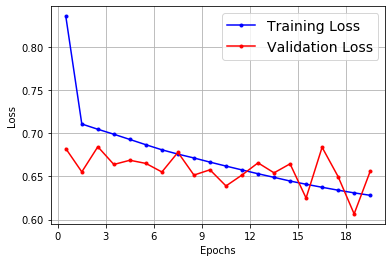

In [94]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [153]:
tf.random.set_seed(42)
model = keras.models.Sequential(
    [keras.layers.LSTM(15, return_sequences=True, input_shape=[None,1]),

    keras.layers.LSTM(15, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(4))
    ]
)
print(f"X_train_shape before processing = {X_train.shape}")
model.compile(loss="mse", optimizer=optimizer)
print(model.summary())
X_train, Y_train, X_valid, Y_valid = get_data(data)
history = model.fit(X_train,Y_train, epochs=20, validation_data=(X_valid, Y_valid))

X_train_shape before processing = (592458, 8, 1)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 15)          1020      
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 15)          1860      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 4)           64        
Total params: 2,944
Trainable params: 2,944
Non-trainable params: 0
_________________________________________________________________
None
X_train_shape initial = (592458, 8) (253910, 8)
X_train_shape after normalize = (592458, 8) (253910, 8)
Epoch 1/20
18515/18515 [==============================] - 134s 7ms/step - loss: 0.7479 - val_loss: 0.5306
Epoch 2/20
18515/18515 [==============================] - 142s 8ms/step - loss: 0.6733 - val_loss: 0.5366
Epoch 3/20


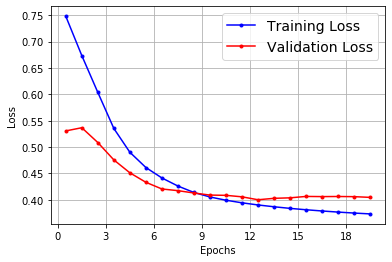

In [154]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

This model seems to be preforming well so we save it

In [155]:
model.save("lstm_4_outputs.h5")

In [156]:
y_pred = model.predict(X_valid)
y_pred = np.mean(y_pred, axis=1)
y_pred = y_pred[:,np.newaxis, :]

In [157]:
rms = keras.metrics.mean_squared_error(y_pred, Y_valid)
print(np.mean(rms))

0.2965613627579735


In [158]:
test_data = pd.read_csv("test_set (1).csv")

In [193]:
X_test = test_data[['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
        'i_q']]
#convert to numpy
X_test = X_test.to_numpy()
#normalize 
X_test = X_test/np.linalg.norm(X_test, ord=2, axis=1, keepdims=True)
#reshape for prediction
X_test = X_test[:,:,np.newaxis]

In [194]:
test_preds = model.predict(X_test)

In [195]:
#get mean of predictions
test_preds = np.mean(test_preds, axis=1)

In [197]:
#get final result
predicted_temperatures = pd.DataFrame(test_preds, columns=['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'])

In [198]:
predicted_temperatures.to_csv("predicted_temperatures.csv",index=False)

In [199]:
#final RMSE for validation set
for i in range(4):
    rmse = keras.metrics.RootMeanSquaredError()
    rmse.update_state(y_pred[:,:,i], Y_valid[:,:,i])
    print(rmse.result().numpy())

0.6647956
0.4221198
0.5203623
0.5434429


In [200]:
test_preds = model.predict(X_test)
test_preds = np.mean(test_preds, axis=1)



In [201]:
test_Y = pd.read_csv("test_solutions (1).csv")[['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']]
test_Y = test_Y.to_numpy()

print(test_preds.shape)

(76423, 4)


In [202]:
results = []
for i in range(4):
    rmse = keras.metrics.RootMeanSquaredError()
    rmse.update_state(test_Y[:,i], test_preds[:,i])
    results.append(rmse.result().numpy())

In [203]:
results = np.array(results)
rmse_result = pd.DataFrame(results.reshape(1,4), columns=["RMSE_pm", "RMSE_stator_yoke", "RMSE_stator_tooth", "RMSE_stator_winding"])

In [204]:
rmse_result.to_csv("rmse_results.csv",index=False)

In [191]:
rmse_result

,RMSE_pm,RMSE_stator_yoke,RMSE_stator_tooth,RMSE_stator_winding
0,0.942736,0.405681,0.566654,0.625811


In [211]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate  in (1,2,4,8) *2:
    model.add(keras.layers.Conv1D(filters=40, kernel_size=2, padding="causal", activation="selu", 
                                  kernel_initializer="lecun_normal", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=4, kernel_size=4))
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
18515/18515 [==============================] - 119s 6ms/step - loss: 0.3282 - val_loss: 0.3754
Epoch 2/10
18515/18515 [==============================] - 118s 6ms/step - loss: 0.2542 - val_loss: 0.3736
Epoch 3/10
18515/18515 [==============================] - 119s 6ms/step - loss: 0.2397 - val_loss: 0.3419
Epoch 4/10
18515/18515 [==============================] - 118s 6ms/step - loss: 0.2305 - val_loss: 0.3558
Epoch 5/10
18515/18515 [==============================] - 120s 6ms/step - loss: 0.2248 - val_loss: 0.3460
Epoch 6/10
18515/18515 [==============================] - 117s 6ms/step - loss: 0.2200 - val_loss: 0.3631
Epoch 7/10
18515/18515 [==============================] - 118s 6ms/step - loss: 0.2163 - val_loss: 0.3516
Epoch 8/10
18515/18515 [==============================] - 118s 6ms/step - loss: 0.2130 - val_loss: 0.3680
Epoch 9/10
18515/18515 [==============================] - 118s 6ms/step - loss: 0.2099 - val_loss: 0.3965
Epoch 10/10
18515/18515 [=====================

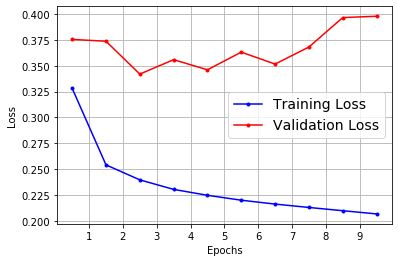

In [212]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [213]:
test_preds = model.predict(X_test)

In [214]:
test_preds.shape

(76423, 5, 4)